# Step 1:  Loading and Preprocessing the Dataset

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

# Load the dataset
data = pd.read_csv('reddit_opinion_PSE_ISR.csv')

data['post_text'] = data['post_title'] + ' ' + data['post_self_text']

# Drop unnecessary columns
data.drop(columns=['post_title', 'post_self_text'], inplace=True)

# Drop rows with missing values
data.dropna(subset=['post_text', 'self_text', 'post_created_time', 'created_time', 'subreddit'], inplace=True)

# Remove unnecessary columns
data = data[['created_time', 'post_created_time', 'self_text', 'post_text']]

# Define preprocessing function
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word.lower()) for word in filtered_tokens]
    # Join tokens back into text
    return ' '.join(lemmatized_tokens)

# Apply preprocessing to text columns
data['clean_self_text'] = data['self_text'].apply(preprocess_text)
data['clean_post_text'] = data['post_text'].apply(preprocess_text)

# Split the Dataset into Training and Test Set
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Step 2: Sentiment Analysis with VADER

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Define function to get sentiment using VADER
def get_sentiment_vader(text):
    sentiment_score = sia.polarity_scores(text)
    if sentiment_score['compound'] >= 0.05:
        return 'positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Sentiment Analysis with VADER on training set
train_data['sentiment_self_text_vader'] = train_data['clean_self_text'].apply(get_sentiment_vader)
train_data['sentiment_post_text_vader'] = train_data['clean_post_text'].apply(get_sentiment_vader)

# Sentiment Analysis with VADER on test set
test_data['sentiment_self_text_vader'] = test_data['clean_self_text'].apply(get_sentiment_vader)
test_data['sentiment_post_text_vader'] = test_data['clean_post_text'].apply(get_sentiment_vader)

# Step 3: Sentiment Analysis with lstm Model

## LSTM

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from gensim.models import KeyedVectors

# Load pre-trained GloVe word embeddings
glove_file = '/Users/arafathjazeeb/Library/CloudStorage/OneDrive-UniversityofPisa/Erasmus/Text Analytics/Project/glove.6B/glove.6B.300d.txt'
word_vectors = KeyedVectors.load_word2vec_format(glove_file, binary=False)


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from textblob import TextBlob  # Import TextBlob library for sentiment analysis

# # Function to get sentiment score using TextBlob
# def get_sentiment_vader(text):
#     blob = TextBlob(text)
#     polarity = blob.sentiment.polarity
#     if polarity == 0:
#         return 'neutral'
#     elif polarity > 0:
#         return 'positive'
#     else:
#         return 'negative'

# # Apply TextBlob sentiment analysis to 'clean_self_text' and 'clean_post_text'
# data['sentiment_self_text_vader'] = data['clean_self_text'].apply(get_sentiment_vader)
# data['sentiment_post_text_vader'] = data['clean_post_text'].apply(get_sentiment_vader)

# Split dataset into train and test sets
#train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define your LSTM model
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SentimentClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        out = self.softmax(out)
        return out

# Define your dataset class
import torch
from torch.utils.data import Dataset
from nltk.tokenize import word_tokenize
import torch.nn.utils.rnn as rnn_utils

class CustomDataset(Dataset):
    def __init__(self, texts, labels, word_vectors, max_length=None):
        self.texts = texts
        self.labels = labels
        self.word_vectors = word_vectors
        self.max_length = max_length
        self.label_map = {'positive': 0, 'negative': 1, 'neutral': 2}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = word_tokenize(text)  #tokenizing
        if self.max_length is not None:
            tokens = tokens[:self.max_length]
        indexed_tokens = [self.word_vectors.key_to_index[token] if token in self.word_vectors.key_to_index else 0 for token in tokens]
        label = self.label_map[self.labels[idx]]  # Map label to numerical value
        return indexed_tokens, label

# Create collate function to pad sequences
def collate_batch(batch):
    # Sort batch by sequence length
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sequences, labels = zip(*batch)
    # Pad sequences
    padded_sequences = rnn_utils.pad_sequence([torch.tensor(seq) for seq in sequences], batch_first=True)
    return padded_sequences, torch.tensor(labels)

# Define data loaders with collate function
train_loader = DataLoader(CustomDataset(train_data['clean_self_text'].tolist(), train_data['sentiment_self_text_vader'].tolist(), word_vectors=word_vectors), batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(CustomDataset(test_data['clean_self_text'].tolist(), test_data['sentiment_self_text_vader'].tolist(), word_vectors=word_vectors), batch_size=batch_size, collate_fn=collate_batch)


In [ ]:
import torch.nn.functional as F

# Define your LSTM model with trainable embeddings
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])
        return out

# # Define data loaders
# batch_size = 64
# train_loader = DataLoader(CustomDataset(train_data['clean_self_text'].tolist(), train_data['sentiment_self_text_vader'].tolist()), batch_size=batch_size, shuffle=True, tokenizer=)
# test_loader = DataLoader(CustomDataset(test_data['clean_self_text'].tolist(), test_data['sentiment_self_text_vader'].tolist()), batch_size=batch_size)

# Define model parameters and instantiate the model
vocab_size = len(word_vectors)  # Set this to the size of your vocabulary
embedding_dim = 300  # Adjust as needed
hidden_dim = 128
output_dim = 3  # Number of classes: positive, negative, neutral
model = SentimentClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the LSTM model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}')

# Test the trained model
model.eval()
predictions_self_text_lstm = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_self_text_lstm.extend(predicted.tolist())

# Store the predictions in the test_data DataFrame
test_data['sentiment_self_text_lstm'] = predictions_self_text_lstm

# # Evaluate the LSTM predictions compared to SentiWordNet predictions for 'clean_self_text'
# accuracy_self_text_lstm = (test_data['sentiment_self_text_lstm'] == test_data['sentiment_self_text_vader']).mean()
# print(f'Accuracy of LSTM predictions for clean_self_text: {accuracy_self_text_lstm:.4f}')


Epoch 1/5: 100%|██████████| 5863/5863 [2:08:15<00:00,  1.31s/it]  


Epoch 1/5, Train Loss: 0.5012


Epoch 2/5: 100%|██████████| 5863/5863 [1:50:09<00:00,  1.13s/it]  


Epoch 2/5, Train Loss: 0.2170


Epoch 3/5: 100%|██████████| 5863/5863 [1:45:48<00:00,  1.08s/it]


Epoch 3/5, Train Loss: 0.1654


Epoch 4/5: 100%|██████████| 5863/5863 [1:48:09<00:00,  1.11s/it]  


Epoch 4/5, Train Loss: 0.1368


Epoch 5/5: 100%|██████████| 5863/5863 [1:46:45<00:00,  1.09s/it]  


Epoch 5/5, Train Loss: 0.1159
Accuracy of LSTM predictions for clean_self_text: 0.0000


In [ ]:
# Define the mapping dictionary
label_map_inverse = {0: 'positive', 1: 'negative', 2: 'neutral'}

# Convert numerical labels predicted by the LSTM model back to sentiment categories
predicted_self_text_sentiments_lstm = [label_map_inverse[label] for label in predictions_self_text_lstm]

# Calculate accuracy by comparing predicted sentiment categories with original sentiment categories
accuracy_self_text_lstm = (predicted_self_text_sentiments_lstm == test_data['sentiment_self_text_vader']).mean()
print(f'Accuracy of LSTM predictions for clean_self_text: {accuracy_self_text_lstm:.4f}')


Accuracy of LSTM predictions for clean_self_text: 0.3901


In [ ]:
# Define data loaders with collate function
train_loader = DataLoader(CustomDataset(train_data['clean_post_text'].tolist(), train_data['sentiment_post_text_vader'].tolist(), word_vectors=word_vectors), batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(CustomDataset(test_data['clean_post_text'].tolist(), test_data['sentiment_post_text_vader'].tolist(), word_vectors=word_vectors), batch_size=batch_size, collate_fn=collate_batch)

# Define your LSTM model with trainable embeddings
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Define model parameters and instantiate the model
vocab_size = len(word_vectors)  # Set this to the size of your vocabulary
embedding_dim = 300  # Adjust as needed
hidden_dim = 128
output_dim = 3  # Number of classes: positive, negative, neutral
model = SentimentClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the LSTM model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}')

# Test the trained model
model.eval()
predictions_post_text_lstm = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_post_text_lstm.extend(predicted.tolist())

# Store the predictions in the test_data DataFrame
test_data['sentiment_post_text_lstm'] = predictions_post_text_lstm

# # Evaluate the LSTM predictions compared to SentiWordNet predictions for 'clean_post_text'
# accuracy_post_text_lstm = (test_data['sentiment_post_text_lstm'] == test_data['sentiment_post_text_vader']).mean()
# print(f'Accuracy of LSTM predictions for clean_post_text: {accuracy_post_text_lstm:.4f}')


Epoch 1/5: 100%|██████████| 5863/5863 [3:29:23<00:00,  2.14s/it]  


Epoch 1/5, Train Loss: 0.1404


Epoch 2/5: 100%|██████████| 5863/5863 [4:46:40<00:00,  2.93s/it]   


Epoch 2/5, Train Loss: 0.0092


Epoch 3/5: 100%|██████████| 5863/5863 [6:14:16<00:00,  3.83s/it]       


Epoch 3/5, Train Loss: 0.0041


Epoch 4/5: 100%|██████████| 5863/5863 [11:05:33<00:00,  6.81s/it]    


Epoch 4/5, Train Loss: 0.0026


Epoch 5/5: 100%|██████████| 5863/5863 [3:58:26<00:00,  2.44s/it]     


Epoch 5/5, Train Loss: 0.0011
Accuracy of LSTM predictions for clean_post_text: 0.0000


In [ ]:
df.to_csv('lstm_processed.csv', index=False)

In [ ]:
# Define the mapping dictionary
label_map_inverse = {0: 'positive', 1: 'negative', 2: 'neutral'}

# Convert numerical labels predicted by the LSTM model back to sentiment categories
predicted_post_text_sentiments_lstm = [label_map_inverse[label] for label in predictions_post_text_lstm]

# Calculate accuracy by comparing predicted sentiment categories with original sentiment categories
accuracy_post_text_lstm = (predicted_post_text_sentiments_lstm == test_data['sentiment_post_text_vader']).mean()
print(f'Accuracy of LSTM predictions for clean_post_text: {accuracy_post_text_lstm:.4f}')


Accuracy of LSTM predictions for clean_post_text: 0.5494


# Step 4: Visualization of Sentiment Over Time

In [ ]:
# Convert 'created_time' to datetime
train_data['created_time'] = pd.to_datetime(train_data['created_time'])

# Extract date from 'created_time'
train_data['created_date'] = train_data['created_time'].dt.date


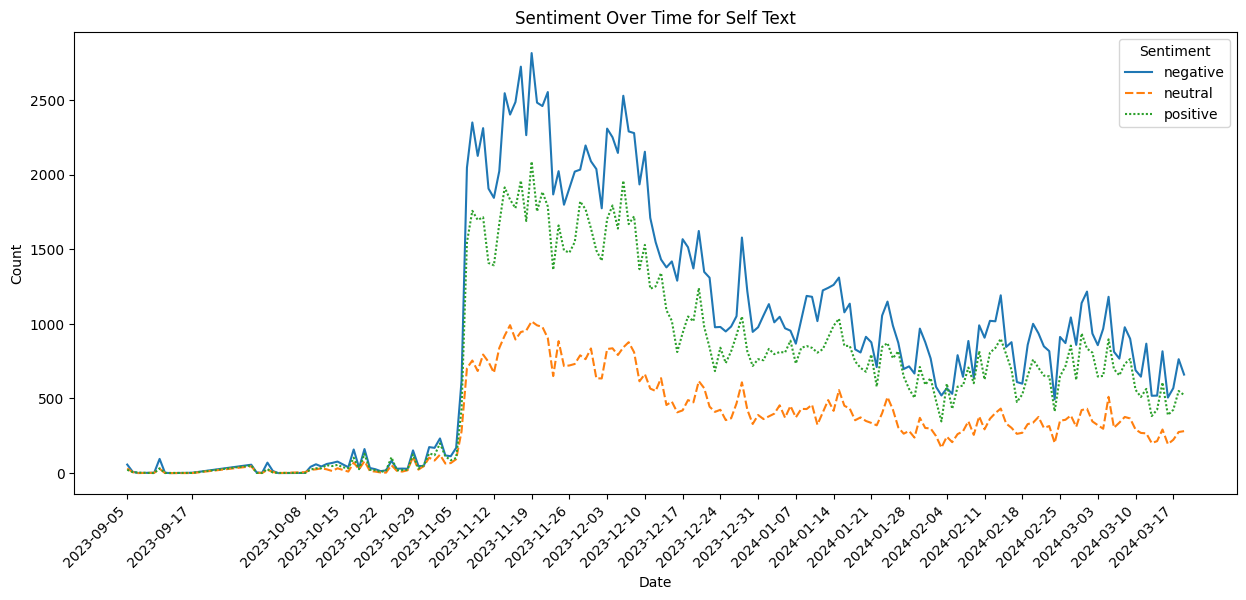

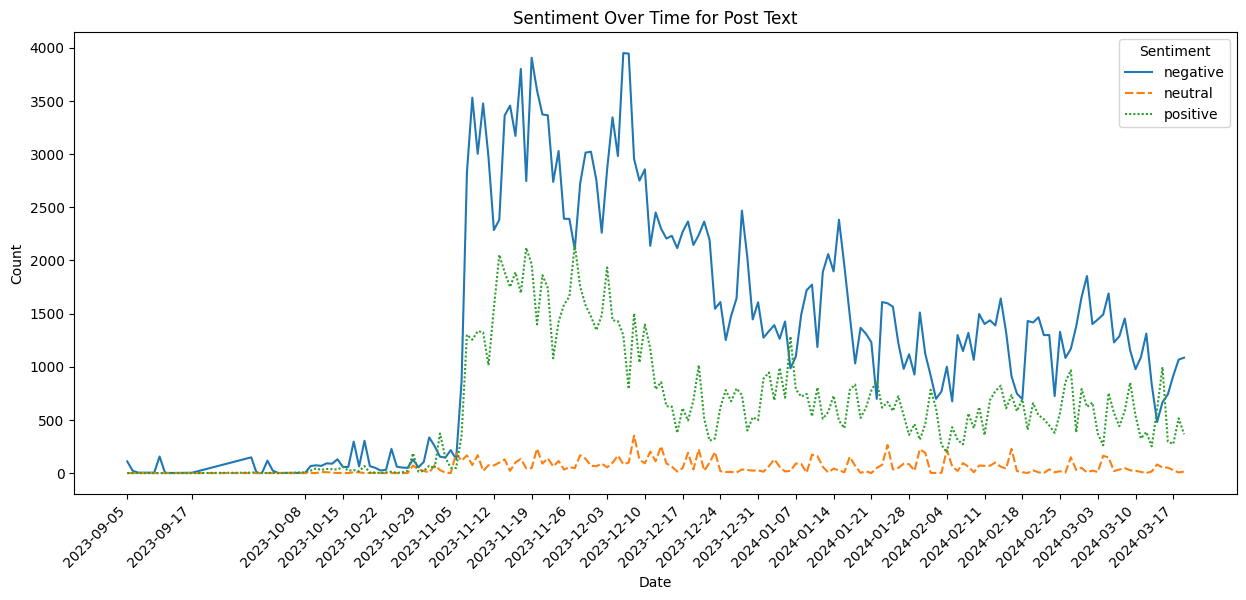

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Convert sentiment scores to DataFrame
sentiment_over_time = pd.DataFrame(train_data[['created_time', 'sentiment_self_text_vader', 'sentiment_post_text_vader',]])

# Plot sentiment over time for self text
# Group by 'created_time' and sentiment category, then calculate counts
sentiment_counts_per_day_self = sentiment_over_time.groupby([sentiment_over_time['created_time'].dt.date, 'sentiment_self_text_vader']).size().unstack(fill_value=0)

# Plot sentiment over time for self text
plt.figure(figsize=(15, 6))

# Plot lines for each sentiment category
sns.lineplot(data=sentiment_counts_per_day_self, markers=False)  # Disable markers to use lines only

plt.title('Sentiment Over Time for Self Text')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')

# Display every 7th date on x-axis
ticks_to_show = sentiment_counts_per_day_self.index[::7]
plt.xticks(ticks_to_show, rotation=45, ha='right')
plt.show()


# Plot sentiment over time for post text
# Group by 'created_time' and sentiment category, then calculate counts
sentiment_counts_per_day_post = sentiment_over_time.groupby([sentiment_over_time['created_time'].dt.date, 'sentiment_post_text_vader']).size().unstack(fill_value=0)

# Plot sentiment over time for self text
plt.figure(figsize=(15, 6))

# Plot lines for each sentiment category
sns.lineplot(data=sentiment_counts_per_day_post, markers=False)  # Disable markers to use lines only

plt.title('Sentiment Over Time for Post Text')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')

# Display every 7th date on x-axis
ticks_to_show = sentiment_counts_per_day_post.index[::7]
plt.xticks(ticks_to_show, rotation=45, ha='right')
plt.show()


# Step 5: Topic Modeling and Sentiment Analysis by Topic

## Topic Modeling

In [ ]:
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.feature_extraction.text import CountVectorizer

# # Define function for topic modeling
# def get_topics(text_data):
#     vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
#     dtm = vectorizer.fit_transform(text_data)
#     lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
#     lda_model.fit(dtm)
#     return lda_model, vectorizer

# # Fit LDA models for self text and post text
# lda_self_text, vectorizer_self_text = get_topics(train_data['clean_self_text'])
# lda_post_text, vectorizer_post_text = get_topics(train_data['clean_post_text'])

# # Get topics for self text and post text
# topics_self_text = lda_self_text.transform(vectorizer_self_text.transform(train_data['clean_self_text']))
# topics_post_text = lda_post_text.transform(vectorizer_post_text.transform(train_data['clean_post_text']))

# # Assign topics to DataFrame
# train_data['topic_self_text'] = topics_self_text.argmax(axis=1)
# train_data['topic_post_text'] = topics_post_text.argmax(axis=1)


In [ ]:
import re
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim

# Tokenize function
def tokenize(text):
    # Split the text into tokens using regular expressions
    tokens = re.findall(r'\w+', text.lower())
    return tokens

# Load your dataset
# Assuming train_data is your DataFrame with 'clean_self_text' and 'clean_post_text' columns
# If it's not already loaded, you can load it here

# Tokenize 'clean_self_text' and 'clean_post_text' columns
train_data['tokenized_self_text'] = train_data['clean_self_text'].apply(tokenize)
train_data['tokenized_post_text'] = train_data['clean_post_text'].apply(tokenize)

# Create Dictionary for self text
id2word_self_text = corpora.Dictionary(train_data['tokenized_self_text'])

# Create Corpus for self text
corpus_self_text = [id2word_self_text.doc2bow(text) for text in train_data['tokenized_self_text']]

# Create Dictionary for post text
id2word_post_text = corpora.Dictionary(train_data['tokenized_post_text'])

# Create Corpus for post text
corpus_post_text = [id2word_post_text.doc2bow(text) for text in train_data['tokenized_post_text']]

# Train LDA model with 5 topics
num_topics = 3
lda_model_self_text = LdaModel(corpus=corpus_self_text,
                                id2word=id2word_self_text,
                                num_topics=num_topics,
                                random_state=100,
                                update_every=1,
                                chunksize=100,
                                passes=10,
                                alpha='auto',
                                per_word_topics=True)

lda_model_post_text = LdaModel(corpus=corpus_post_text,
                                id2word=id2word_post_text,
                                num_topics=num_topics,
                                random_state=100,
                                update_every=1,
                                chunksize=100,
                                passes=10,
                                alpha='auto',
                                per_word_topics=True)




In [ ]:
# Print the keywords of topics for self text
pprint(lda_model_self_text.print_topics(num_topics=num_topics, num_words=5)[1])

# Print the keywords of topics for post text
pprint(lda_model_post_text.print_topics(num_topics=num_topics, num_words=5)[1])

(1,
 '0.020*"people" + 0.014*"dont" + 0.014*"like" + 0.011*"think" + 0.009*"one"')
(1,
 '0.021*"people" + 0.016*"israel" + 0.010*"hamas" + 0.010*"dont" + '
 '0.009*"like"')


In [ ]:
# Get topics for self text
topics_self_text = lda_model_self_text.get_document_topics(corpus_self_text)

# Get topics for post text
topics_post_text = lda_model_post_text.get_document_topics(corpus_post_text)

# Store topic numbers in DataFrame
train_data['topic_self_text'] = [max(topic, key=lambda x: x[1])[0] for topic in topics_self_text]
train_data['topic_post_text'] = [max(topic, key=lambda x: x[1])[0] for topic in topics_post_text]

# Print the DataFrame to verify the stored topics
#print(train_data[['topic_self_text', 'topic_post_text']])


In [ ]:
# Visualize the topics in LDA for self text
pyLDAvis.enable_notebook()
vis_self_text = pyLDAvis.gensim.prepare(lda_model_self_text, corpus_self_text, id2word_self_text)
vis_self_text

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.280553  0.059864       1        1  48.634157
0      0.081023 -0.242516       2        1  27.154158
2      0.199529  0.182652       3        1  24.211684, topic_info=            Term           Freq          Total Category  logprob  loglift
112        hamas  106281.000000  106281.000000  Default  30.0000  30.0000
119          jew   72559.000000   72559.000000  Default  29.0000  29.0000
117       israel  189876.000000  189876.000000  Default  28.0000  28.0000
92          gaza   55053.000000   55053.000000  Default  27.0000  27.0000
144  palestinian  110909.000000  110909.000000  Default  26.0000  26.0000
..           ...            ...            ...      ...      ...      ...
228        would   17332.928697   71231.892140   Topic3  -5.0221   0.0050
144  palestinian   20082.248240  110909.611973   Topic3  -4.8748  -0.2905
581     genocide   10870.931738   23601.833544   Topic3  -5.4886   0.6431
29          also   10737.554765   42676.330030   Topic3  -5.5009   0.0384
351         year   10022.411323   30163.949307   Topic3  -5.5699   0.3165

[176 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
949       2  0.999811     1948
440       3  0.999870        7
2012      3  0.999919      7th
1518      3  0.999893      aid
29        1  0.457842     also
...     ...       ...      ...
351       3  0.332251     year
195       1  0.999985    youre
521       2  0.999883  zionism
337       1  0.385404  zionist
337       2  0.614566  zionist

[196 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [ ]:
# Get the top tokens for topic 1 with their probabilities
topic_tokens = lda_model_self_text.show_topic(2, topn=20)

# Sort the tokens by probability in descending order
topic_tokens_sorted = sorted(topic_tokens, key=lambda x: x[1], reverse=True)

# Print the tokens, their probabilities, and sentiments
for token, prob in topic_tokens_sorted:
    # Retrieve the sentiment information for the token from your dataset

    sentiment = train_data[train_data['tokenized_self_text'].apply(lambda x: token in x)]['sentiment_self_text_vader'].values[0]
    # Print the token, its probability, and sentiment
    print(f'Token: {token}, Probability: {prob}, Sentiment: {sentiment}')

Token: hamas, Probability: 0.04041312634944916, Sentiment: positive
Token: israel, Probability: 0.03147361800074577, Sentiment: positive
Token: gaza, Probability: 0.02093362994492054, Sentiment: positive
Token: war, Probability: 0.016935426741838455, Sentiment: negative
Token: civilian, Probability: 0.015576748177409172, Sentiment: negative
Token: israeli, Probability: 0.009246411733329296, Sentiment: positive
Token: idf, Probability: 0.008793015964329243, Sentiment: negative
Token: terrorist, Probability: 0.008405977860093117, Sentiment: positive
Token: palestinian, Probability: 0.007636270951479673, Sentiment: positive
Token: attack, Probability: 0.007611101493239403, Sentiment: negative
Token: child, Probability: 0.007577188778668642, Sentiment: positive
Token: killed, Probability: 0.006831401027739048, Sentiment: negative
Token: would, Probability: 0.0065908427350223064, Sentiment: positive
Token: military, Probability: 0.006484270095825195, Sentiment: positive
Token: death, Probab

In [ ]:
# Get the top tokens for topic 1 with their probabilities
topic_tokens = lda_model_self_text.show_topic(1, topn=20)

# Sort the tokens by probability in descending order
topic_tokens_sorted = sorted(topic_tokens, key=lambda x: x[1], reverse=True)

# Print the tokens, their probabilities, and sentiments
for token, prob in topic_tokens_sorted:
    # Retrieve the sentiment information for the token from your dataset

    sentiment = train_data[train_data['tokenized_self_text'].apply(lambda x: token in x)]['sentiment_self_text_vader'].values[0]
    # Print the token, its probability, and sentiment
    print(f'Token: {token}, Probability: {prob}, Sentiment: {sentiment}')

Token: people, Probability: 0.01956883817911148, Sentiment: positive
Token: dont, Probability: 0.013642583973705769, Sentiment: positive
Token: like, Probability: 0.013524296693503857, Sentiment: positive
Token: think, Probability: 0.010599455796182156, Sentiment: neutral
Token: one, Probability: 0.009307789616286755, Sentiment: positive
Token: im, Probability: 0.007438952103257179, Sentiment: negative
Token: know, Probability: 0.007220542058348656, Sentiment: positive
Token: say, Probability: 0.006867778953164816, Sentiment: negative
Token: would, Probability: 0.006857003550976515, Sentiment: positive
Token: want, Probability: 0.00684494711458683, Sentiment: positive
Token: get, Probability: 0.006719346158206463, Sentiment: positive
Token: thats, Probability: 0.006342627108097076, Sentiment: positive
Token: make, Probability: 0.006238054018467665, Sentiment: positive
Token: see, Probability: 0.005767639260739088, Sentiment: negative
Token: even, Probability: 0.005765161477029324, Sent

In [ ]:
# Get the top tokens for topic 0 with their probabilities
topic_tokens = lda_model_self_text.show_topic(0, topn=20)

# Sort the tokens by probability in descending order
topic_tokens_sorted = sorted(topic_tokens, key=lambda x: x[1], reverse=True)

# Print the tokens, their probabilities, and sentiments
for token, prob in topic_tokens_sorted:
    # Retrieve the sentiment information for the token from your dataset

    sentiment = train_data[train_data['tokenized_self_text'].apply(lambda x: token in x)]['sentiment_self_text_vader'].values[0]
    # Print the token, its probability, and sentiment
    print(f'Token: {token}, Probability: {prob}, Sentiment: {sentiment}')

Token: israel, Probability: 0.03032989427447319, Sentiment: positive
Token: palestinian, Probability: 0.027579523622989655, Sentiment: positive
Token: jew, Probability: 0.024600761011242867, Sentiment: positive
Token: arab, Probability: 0.016166336834430695, Sentiment: positive
Token: state, Probability: 0.015998512506484985, Sentiment: positive
Token: land, Probability: 0.013219669461250305, Sentiment: positive
Token: country, Probability: 0.012715032324194908, Sentiment: negative
Token: jewish, Probability: 0.011262299492955208, Sentiment: positive
Token: palestine, Probability: 0.010763540863990784, Sentiment: positive
Token: right, Probability: 0.009241483174264431, Sentiment: positive
Token: muslim, Probability: 0.008818571455776691, Sentiment: negative
Token: israeli, Probability: 0.007347721140831709, Sentiment: positive
Token: west, Probability: 0.007275675889104605, Sentiment: positive
Token: peace, Probability: 0.007141228299587965, Sentiment: positive
Token: year, Probabilit

Topic 0: Pro Israel

This topic exhibits a sentiment largely positive towards Israel, as indicated by the presence of words like "Israel," "Jew," "State," and "Israeli" with positive sentiment probabilities.
Additionally, terms like "Peace" suggest a favorable viewpoint towards efforts for peace in the region.
While terms like "Muslim" and "War" have negative sentiment probabilities, they are outweighed by the overall positive sentiment towards Israel.

Topic 1: Neutral

This topic does not exhibit a clear bias towards either side of the conflict.
Terms like "People," "Think," "One," and "Would" are generic and do not lean towards any specific stance.
While some terms like "Im" and "Say" have negative sentiment probabilities, the overall tone of the topic remains balanced and nonpartisan.

Topic 2: Pro Palestine

This topic demonstrates a sentiment largely positive towards Palestine, evident from terms such as "Hamas," "Gaza," and "Palestinian" with positive sentiment probabilities.
Words like "Attack" and "Child" suggest empathy towards Palestinian suffering.
Negative sentiment probabilities associated with terms like "War," "Civilian," and "Military" reinforce a viewpoint sympathetic towards Palestinian interests, despite the inclusion of terms like "Israeli" and "IDF."
By analyzing the sentiment probabilities and thematic alignment of each topic, Topic 0 is categorized as "Pro Israel," Topic 1 as "Neutral," and Topic 2 as "Pro Palestine."

In [ ]:

# Visualize the topics in LDA for post text
vis_post_text = pyLDAvis.gensim.prepare(lda_model_post_text, corpus_post_text, id2word_post_text)
vis_post_text

Python(189) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(190) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(191) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(192) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(193) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(194) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(195) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(196) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.030639 -0.127678       1        1  40.313001
0     -0.125761  0.084635       2        1  31.114299
2      0.156400  0.043043       3        1  28.572700, topic_info=         Term           Freq          Total Category  logprob  loglift
21      hamas  646951.000000  646951.000000  Default  30.0000  30.0000
244       jew  360794.000000  360794.000000  Default  29.0000  29.0000
17       gaza  425664.000000  425664.000000  Default  28.0000  28.0000
60       arab  216809.000000  216809.000000  Default  27.0000  27.0000
655  civilian  226970.000000  226970.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
32        one   66304.109489  293883.399540   Topic3  -5.5576  -0.2362
35     people   75608.474840  715135.417086   Topic3  -5.4262  -0.9942
187      time   52664.418992  182064.455163   Topic3  -5.7879   0.0123
251      many   48272.763796  195860.794323   Topic3  -5.8749  -0.1478
14       even   47712.220184  233188.210607   Topic3  -5.8866  -0.3339

[272 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
15059      1  0.999888    112
5175       2  0.999827   1947
805        2  0.999974   1948
648        2  0.999927   1967
19640      3  0.999980      _
...      ...       ...    ...
373        3  0.234033  would
472        1  0.325038   year
472        2  0.450000   year
472        3  0.224968   year
4028       1  0.999824      z

[422 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [ ]:
# Get the top tokens for topic 2 with their probabilities
topic_tokens = lda_model_post_text.show_topic(2, topn=20)

# Sort the tokens by probability in descending order
topic_tokens_sorted = sorted(topic_tokens, key=lambda x: x[1], reverse=True)

# Print the tokens, their probabilities, and sentiments
for token, prob in topic_tokens_sorted:
    # Retrieve the sentiment information for the token from your dataset

    sentiment = train_data[train_data['tokenized_post_text'].apply(lambda x: token in x)]['sentiment_post_text_vader'].values[0]
    # Print the token, its probability, and sentiment
    print(f'Token: {token}, Probability: {prob}, Sentiment: {sentiment}')


Token: hamas, Probability: 0.022707801312208176, Sentiment: positive
Token: gaza, Probability: 0.017758484929800034, Sentiment: positive
Token: israel, Probability: 0.017414730042219162, Sentiment: positive
Token: civilian, Probability: 0.01078599039465189, Sentiment: negative
Token: israeli, Probability: 0.008511128835380077, Sentiment: positive
Token: idf, Probability: 0.007437324617058039, Sentiment: negative
Token: war, Probability: 0.006809533573687077, Sentiment: positive
Token: palestinian, Probability: 0.0067740194499492645, Sentiment: positive
Token: genocide, Probability: 0.005757188890129328, Sentiment: positive
Token: death, Probability: 0.005397251341491938, Sentiment: negative
Token: would, Probability: 0.00491853803396225, Sentiment: negative
Token: child, Probability: 0.004782925825566053, Sentiment: negative
Token: killed, Probability: 0.004747632425278425, Sentiment: negative
Token: people, Probability: 0.004399582277983427, Sentiment: positive
Token: attack, Probabil

In [ ]:
# Get the top tokens for topic 1 with their probabilities
topic_tokens = lda_model_post_text.show_topic(1, topn=20)

# Sort the tokens by probability in descending order
topic_tokens_sorted = sorted(topic_tokens, key=lambda x: x[1], reverse=True)

# Print the tokens, their probabilities, and sentiments
for token, prob in topic_tokens_sorted:
    # Retrieve the sentiment information for the token from your dataset

    sentiment = train_data[train_data['tokenized_post_text'].apply(lambda x: token in x)]['sentiment_post_text_vader'].values[0]
    # Print the token, its probability, and sentiment
    print(f'Token: {token}, Probability: {prob}, Sentiment: {sentiment}')


Token: people, Probability: 0.020522207021713257, Sentiment: positive
Token: israel, Probability: 0.016017569229006767, Sentiment: positive
Token: hamas, Probability: 0.009964481927454472, Sentiment: positive
Token: dont, Probability: 0.009828004986047745, Sentiment: positive
Token: like, Probability: 0.009083036333322525, Sentiment: positive
Token: israeli, Probability: 0.008634286932647228, Sentiment: positive
Token: palestinian, Probability: 0.008275613188743591, Sentiment: positive
Token: im, Probability: 0.0080769844353199, Sentiment: positive
Token: think, Probability: 0.00754728214815259, Sentiment: positive
Token: want, Probability: 0.006616893224418163, Sentiment: negative
Token: would, Probability: 0.006335579324513674, Sentiment: negative
Token: one, Probability: 0.005521633196622133, Sentiment: positive
Token: side, Probability: 0.005381462164223194, Sentiment: negative
Token: even, Probability: 0.0053405179642140865, Sentiment: positive
Token: know, Probability: 0.00523355

In [ ]:
# Get the top tokens for topic 0 with their probabilities
topic_tokens = lda_model_post_text.show_topic(0, topn=20)

# Sort the tokens by probability in descending order
topic_tokens_sorted = sorted(topic_tokens, key=lambda x: x[1], reverse=True)

# Print the tokens, their probabilities, and sentiments
for token, prob in topic_tokens_sorted:
    # Retrieve the sentiment information for the token from your dataset

    sentiment = train_data[train_data['tokenized_post_text'].apply(lambda x: token in x)]['sentiment_post_text_vader'].values[0]
    # Print the token, its probability, and sentiment
    print(f'Token: {token}, Probability: {prob}, Sentiment: {sentiment}')


Token: israel, Probability: 0.024250641465187073, Sentiment: positive
Token: palestinian, Probability: 0.022442279383540154, Sentiment: positive
Token: jew, Probability: 0.014049564488232136, Sentiment: positive
Token: state, Probability: 0.012299234047532082, Sentiment: positive
Token: arab, Probability: 0.010573885403573513, Sentiment: positive
Token: jewish, Probability: 0.008129257708787918, Sentiment: positive
Token: land, Probability: 0.008027258329093456, Sentiment: positive
Token: palestine, Probability: 0.007977619767189026, Sentiment: negative
Token: people, Probability: 0.007584190461784601, Sentiment: positive
Token: israeli, Probability: 0.006843273062258959, Sentiment: positive
Token: would, Probability: 0.006574305240064859, Sentiment: negative
Token: country, Probability: 0.006222931202501059, Sentiment: positive
Token: right, Probability: 0.005260820034891367, Sentiment: positive
Token: west, Probability: 0.0052492269314825535, Sentiment: positive
Token: one, Probabili

Based on the top 20 frequent words, their probabilities, and sentiments, here are the topics found:

1. **Pro Israel**: Topic 1
2. **Pro Palestine**: Topic 2
3. **Neutral**: Topic 0
:

- Topic 1 (Pro Israel): This topic prominently features terms like "Israel," "Israeli," "Jew," "State," and "Peace." The sentiment associated with these terms is mostly positive. It discusses aspects related to Israel, its people, and potential solutions for peace, aligning with a perspective favoring Israel.

- Topic 2 (Pro Palestine): Terms like "Hamas," "Gaza," "Palestinian," "Genocide," and "War" dominate this topic. The sentiment associated with many of these terms is negative, highlighting issues such as war, civilian casualties, and conflict, which are often associated with a pro-Palestine stance.

- Topic 0 (Neutral): This topic contains terms such as "Palestinian," "Arab," "Solution," and "War," with sentiments varying between positive and negative. It presents a mix of terms associated with both sides of the conflict but doesn't strongly lean towards either, suggesting a neutral stance.

Therefore, Topic 1 is labeled as Pro Israel, Topic 2 as Pro Palestine, and Topic 0 as Neutral.

# Step 6: Visualization

## Visualize Sentiment Over Time by Topic

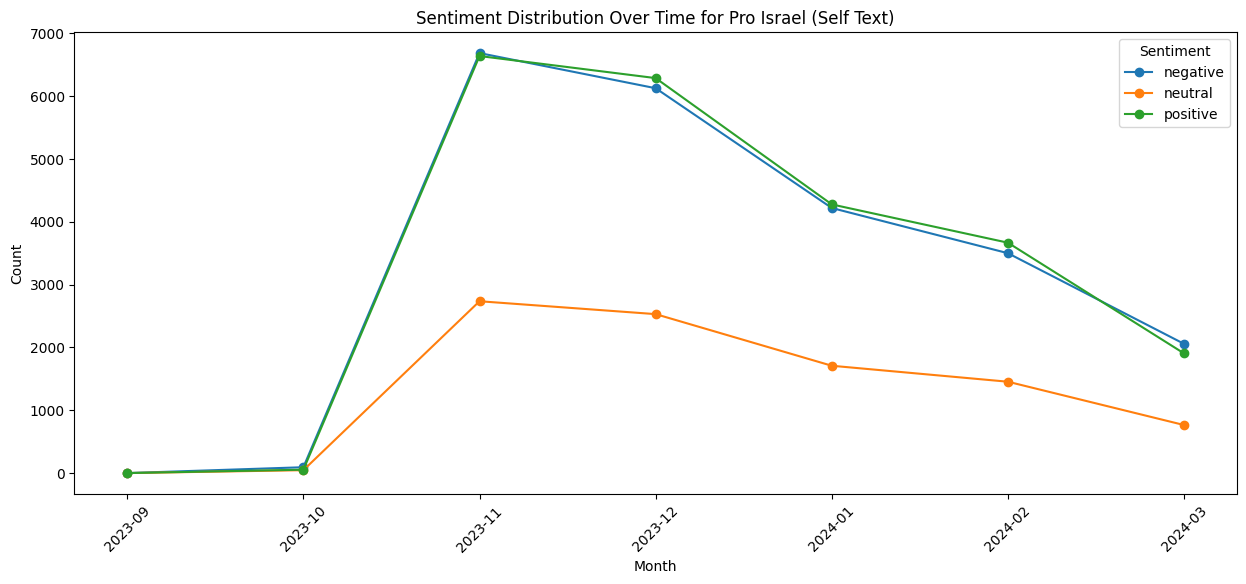

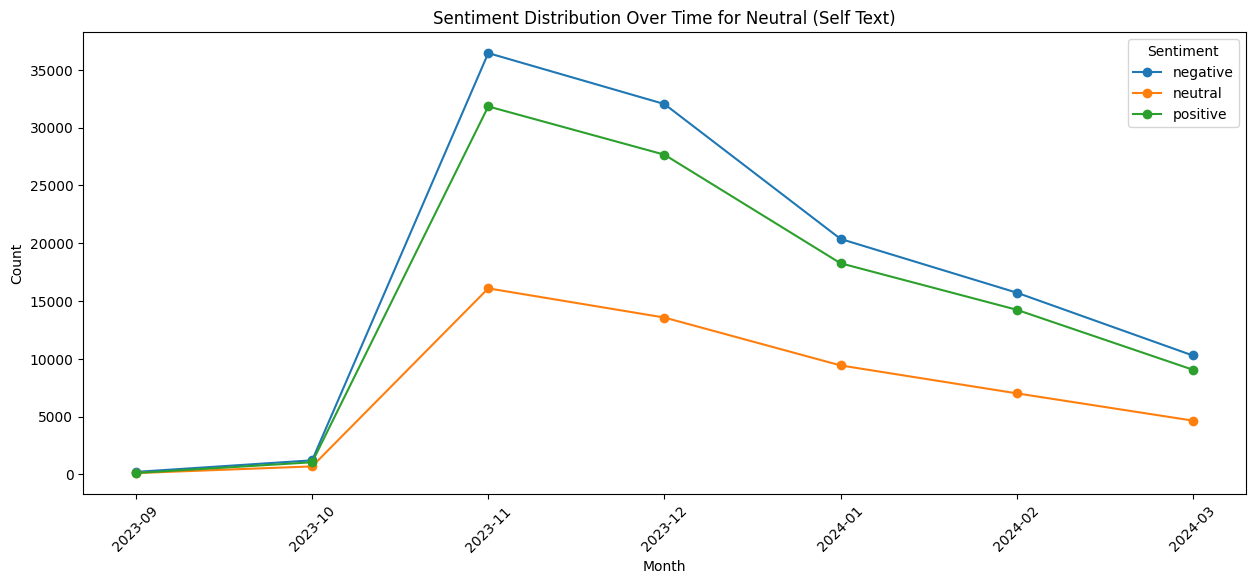

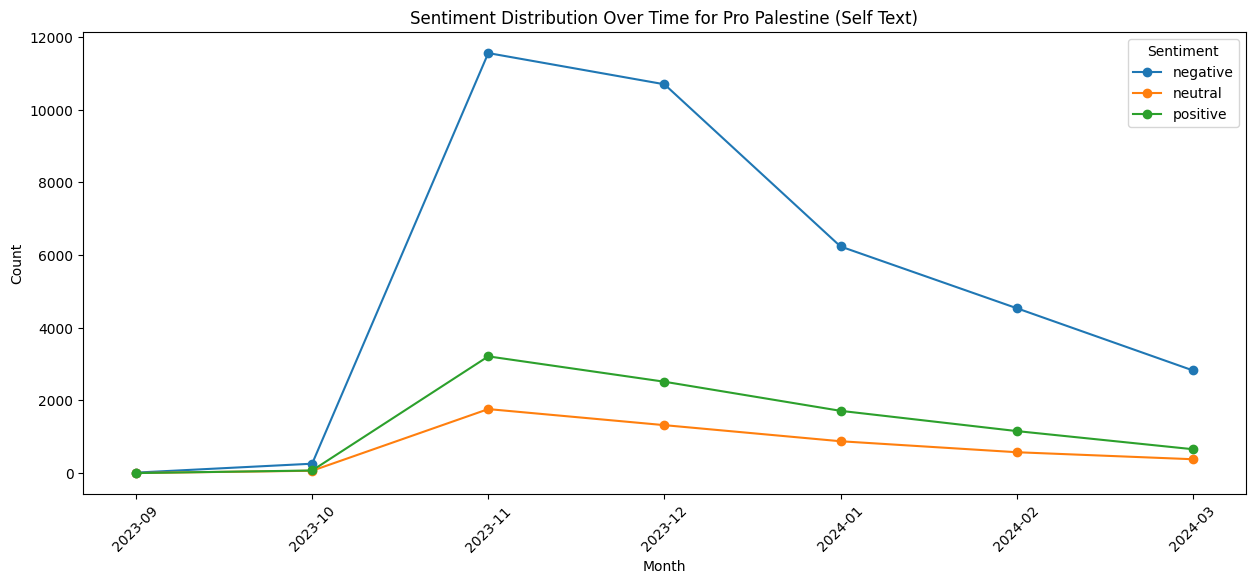

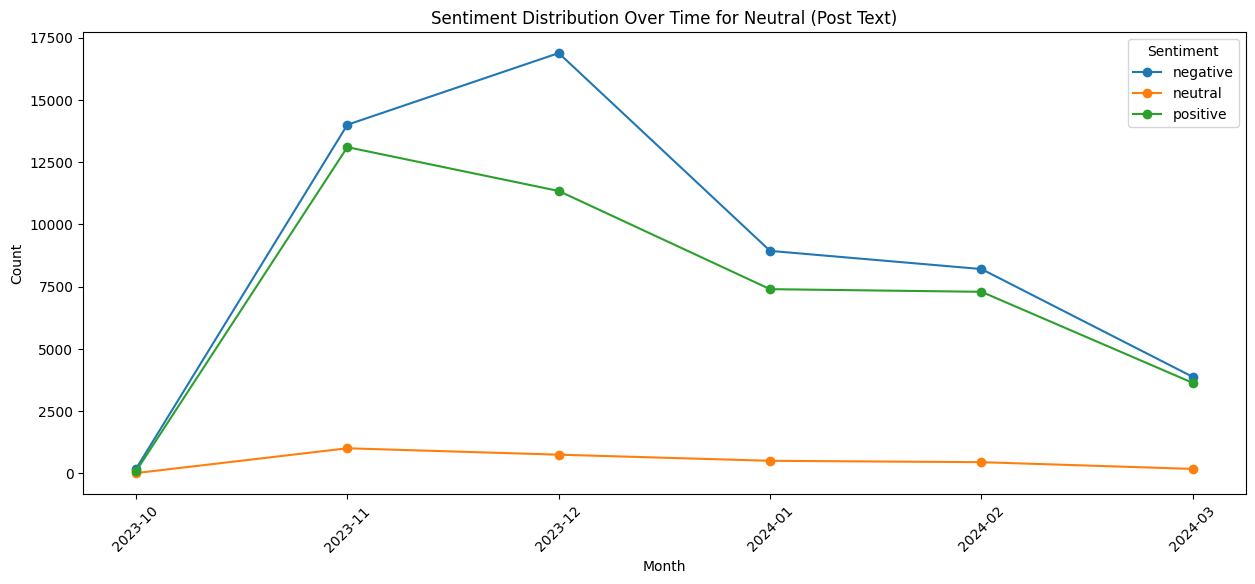

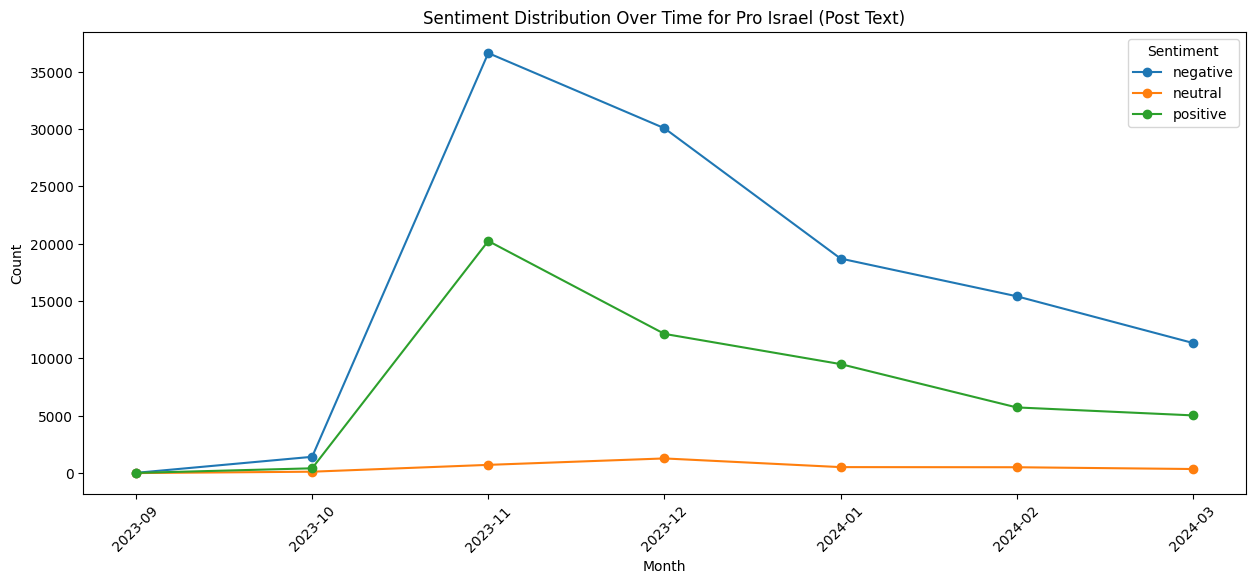

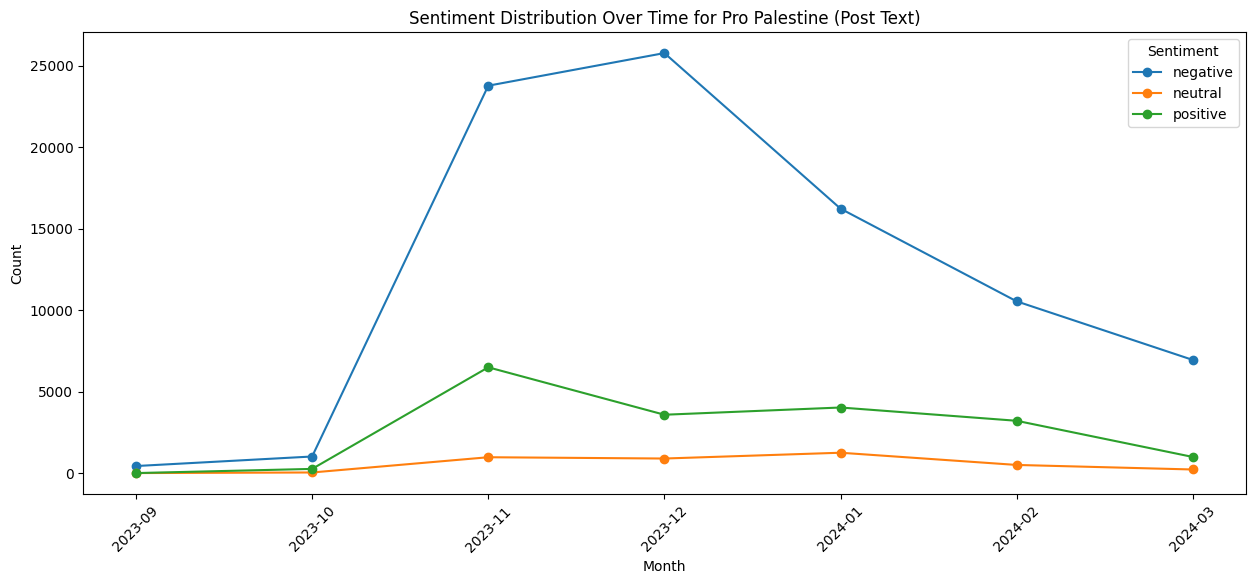

In [ ]:
# Convert 'created_time' to month
train_data['created_month'] = train_data['created_time'].dt.to_period('M')

# Group data by 'topic_self_text', 'created_month', and 'sentiment_self_text_vader', and calculate counts
grouped_self_text_sentiment = train_data.groupby(['topic_self_text', 'created_month', 'sentiment_self_text_vader']).size().reset_index(name='count')

# Group data by 'topic_post_text', 'created_month', and 'sentiment_post_text_vader', and calculate counts
grouped_post_text_sentiment = train_data.groupby(['topic_post_text', 'created_month', 'sentiment_post_text_vader']).size().reset_index(name='count')

# Initialize empty dictionaries to store counts for each topic
self_text_counts_by_topic = {}
post_text_counts_by_topic = {}

# Iterate over each topic and calculate counts of positive, negative, and neutral sentiments for self text
for topic, data in grouped_self_text_sentiment.groupby('topic_self_text'):
    counts = data.pivot(index='created_month', columns='sentiment_self_text_vader', values='count').fillna(0)
    self_text_counts_by_topic[topic] = counts

# Iterate over each topic and calculate counts of positive, negative, and neutral sentiments for post text
for topic, data in grouped_post_text_sentiment.groupby('topic_post_text'):
    counts = data.pivot(index='created_month', columns='sentiment_post_text_vader', values='count').fillna(0)
    post_text_counts_by_topic[topic] = counts


# Define topic names for post text
topic_names_post_text = {
    1: "Pro Israel",
    0: "Neutral",
    2: "Pro Palestine"
}

# Define topic names for self text
topic_names_self_text = {
    0: "Pro Israel",
    1: "Neutral",
    2: "Pro Palestine"
}

# Plot sentiment distribution over time by topic for self text
for topic, counts in self_text_counts_by_topic.items():
    plt.figure(figsize=(15, 6))
    for column in counts.columns:
        x_values = counts.index.astype(str)  # Convert PeriodIndex to strings
        plt.plot(x_values, counts[column], marker='o', label=column)  # Plot directly without using lineplot
    plt.title(f'Sentiment Distribution Over Time for {topic_names_self_text[topic]} (Self Text)')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Sentiment')
    plt.show()

# Plot sentiment distribution over time by topic for post text
for topic, counts in post_text_counts_by_topic.items():
    plt.figure(figsize=(15, 6))
    for column in counts.columns:
        x_values = counts.index.astype(str)  # Convert PeriodIndex to strings
        plt.plot(x_values, counts[column], marker='o', label=column)  # Plot directly without using lineplot
    plt.title(f'Sentiment Distribution Over Time for {topic_names_post_text[topic]} (Post Text)')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Sentiment')
    plt.show()




## Visualize Sentiment Distribution Within Each Topic

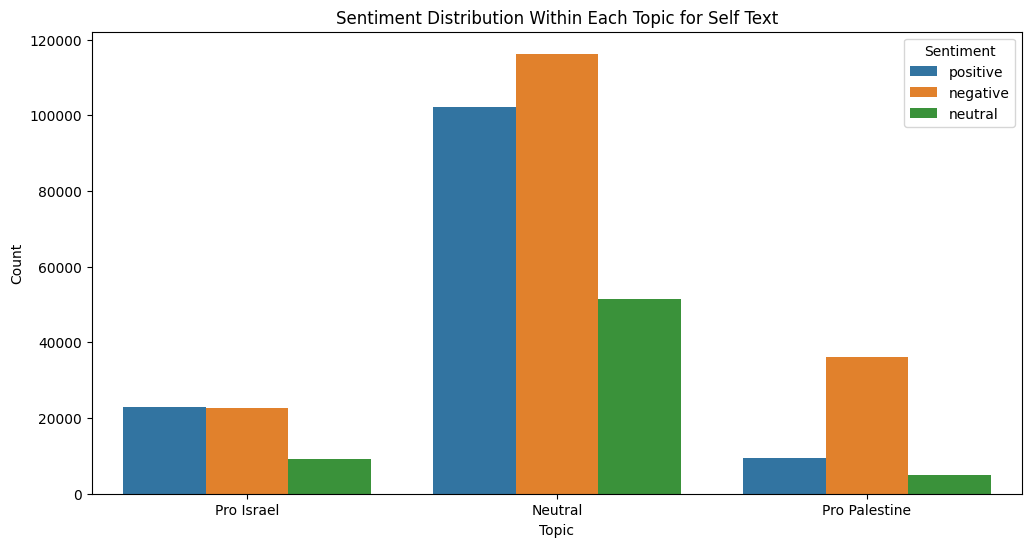

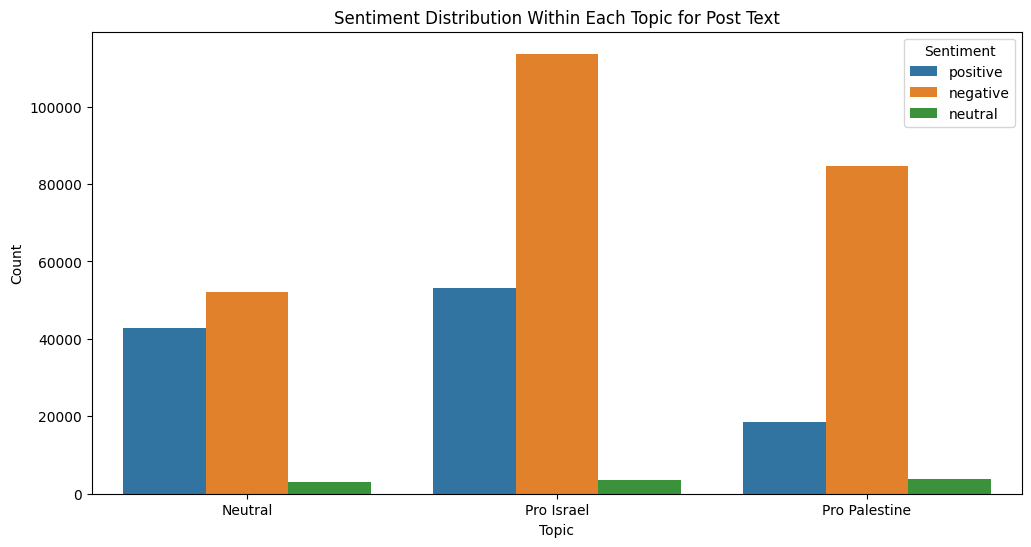

In [ ]:
import seaborn as sns

# Plot sentiment distribution within each topic for self text
plt.figure(figsize=(12, 6))
sns.countplot(x='topic_self_text', hue='sentiment_self_text_vader', data=train_data)
plt.title('Sentiment Distribution Within Each Topic for Self Text')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=[topic_names_self_text[0], topic_names_self_text[1], topic_names_self_text[2]])
plt.legend(title='Sentiment')
plt.show()

# Plot sentiment distribution within each topic for post text
plt.figure(figsize=(12, 6))
sns.countplot(x='topic_post_text', hue='sentiment_post_text_vader', data=train_data)
plt.title('Sentiment Distribution Within Each Topic for Post Text')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=[topic_names_post_text[0], topic_names_post_text[1], topic_names_post_text[2]])
plt.legend(title='Sentiment')
plt.show()


## Word Cloud Generation for Each Sentiment in Self Text

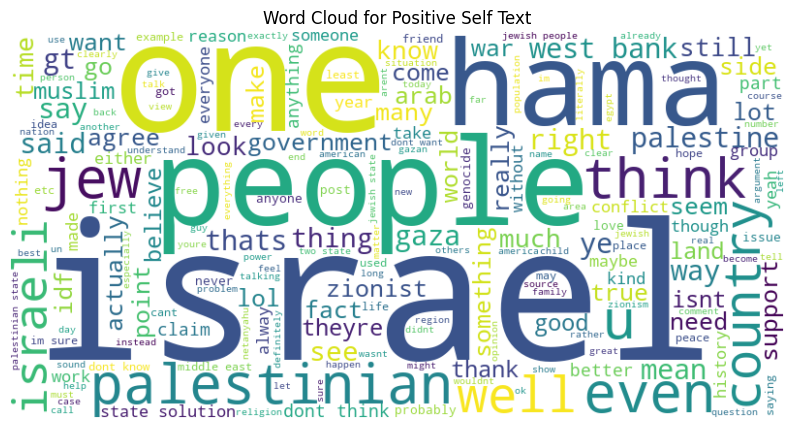

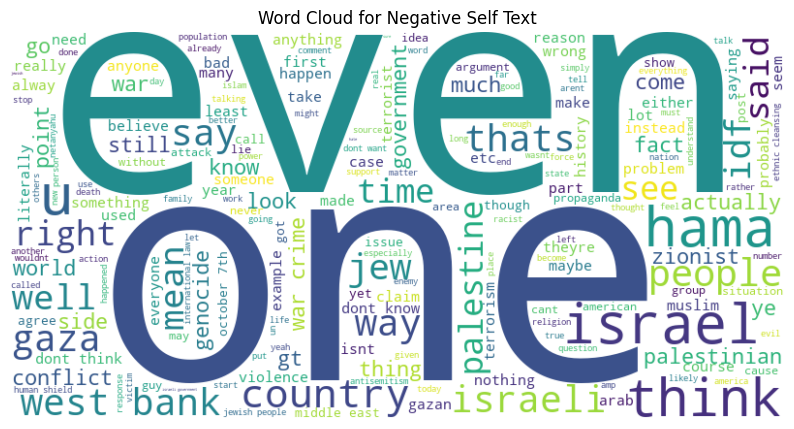

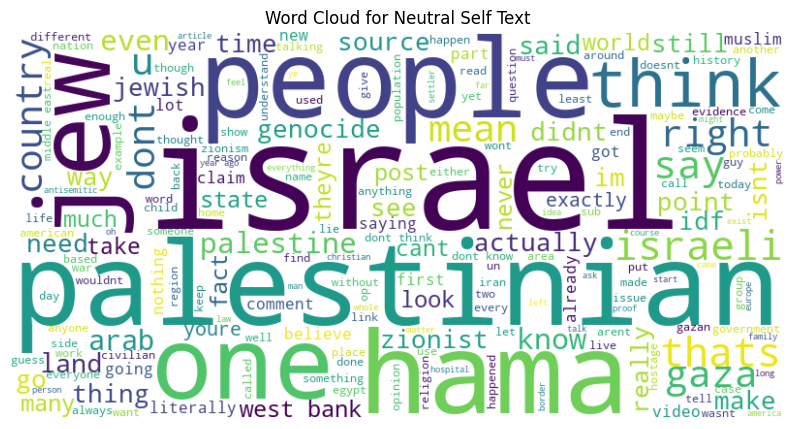

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds for each sentiment in self text
for sentiment in ['positive', 'negative', 'neutral']:
    text = ' '.join(train_data[train_data['sentiment_self_text_vader'] == sentiment]['clean_self_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Self Text')
    plt.axis('off')
    plt.show()


## Word Cloud Generation for Each Sentiment in Post Text

In [ ]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# # Generate word clouds for each sentiment in post text
# for sentiment in ['positive', 'negative', 'neutral']:
#     text = ' '.join(train_data[train_data['sentiment_post_text_vader'] == sentiment]['clean_post_text'])
#     wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
#     plt.figure(figsize=(10, 6))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.title(f'Word Cloud for {sentiment.capitalize()} Post Text')
#     plt.axis('off')
#     plt.show()


# Step 7: Comparison of Sentiment Analysis Performance: VADER vs. lstm

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# # Define function to plot performance metrics
# def plot_performance_metrics(metrics_vader, metrics_lstm, metric_name):
#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.bar(['VADER', 'LSTM'], [metrics_vader[metric_name], metrics_lstm[metric_name]], color=['blue', 'orange'])
#     plt.title(f'Comparison of {metric_name} between VADER and LSTM')
#     plt.xlabel('Model')
#     plt.ylabel(metric_name)
#     plt.ylim(0, 1)

#     plt.subplot(1, 2, 2)
#     sns.heatmap(metrics_vader['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
#     plt.title('Confusion Matrix - VADER')
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.show()

#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     sns.heatmap(metrics_lstm['confusion_matrix'], annot=True, fmt='d', cmap='Oranges', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
#     plt.title('Confusion Matrix - LSTM')
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.show()

# # Calculate performance metrics for VADER
# precision_vader, recall_vader, f1_vader, _ = precision_recall_fscore_support(test_data['ground_truth_sentiment_self_text'], test_data['sentiment_self_text_vader'], average='weighted')
# accuracy_vader = accuracy_score(test_data['ground_truth_sentiment_self_text'], test_data['sentiment_self_text_vader'])
# conf_matrix_vader = confusion_matrix(test_data['ground_truth_sentiment_self_text'], test_data['sentiment_self_text_vader'])

# # Calculate performance metrics for LSTM
# precision_lstm, recall_lstm, f1_lstm, _ = precision_recall_fscore_support(test_data['ground_truth_sentiment_self_text'], test_data['sentiment_self_text_lstm'], average='weighted')
# accuracy_lstm = accuracy_score(test_data['ground_truth_sentiment_self_text'], test_data['sentiment_self_text_lstm'])
# conf_matrix_lstm = confusion_matrix(test_data['ground_truth_sentiment_self_text'], test_data['sentiment_self_text_lstm'])

# # Plot precision
# plot_performance_metrics({'precision': precision_vader, 'confusion_matrix': conf_matrix_vader}, {'precision': precision_lstm, 'confusion_matrix': conf_matrix_lstm}, 'precision')

# # Plot recall
# plot_performance_metrics({'recall': recall_vader, 'confusion_matrix': conf_matrix_vader}, {'recall': recall_lstm, 'confusion_matrix': conf_matrix_lstm}, 'recall')

# # Plot F1-score
# plot_performance_metrics({'f1-score': f1_vader, 'confusion_matrix': conf_matrix_vader}, {'f1-score': f1_lstm, 'confusion_matrix': conf_matrix_lstm}, 'f1-score')

# # Plot Accuracy
# plot_performance_metrics({'accuracy': accuracy_vader, 'confusion_matrix': conf_matrix_vader}, {'accuracy': accuracy_lstm, 'confusion_matrix': conf_matrix_lstm}, 'accuracy')


In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_recall_fscore_support

# # Define function to plot performance metrics
# def plot_performance_metrics(metrics_vader, metrics_lstm, metric_name):
#     plt.figure(figsize=(8, 6))
#     plt.bar(['VADER', 'lstm'], [metrics_vader[metric_name], metrics_lstm[metric_name]], color=['blue', 'orange'])
#     plt.title(f'Comparison of {metric_name} between VADER and lstm')
#     plt.xlabel('Model')
#     plt.ylabel(metric_name)
#     plt.ylim(0, 1)
#     plt.show()

# # Calculate performance metrics for VADER
# precision_vader, recall_vader, f1_vader, _ = precision_recall_fscore_support(test_data['ground_truth_sentiment_self_text'], test_data['sentiment_self_text_vader'], average='weighted')

# # Calculate performance metrics for lstm
# precision_lstm, recall_lstm, f1_lstm, _ = precision_recall_fscore_support(test_data['ground_truth_sentiment_self_text'], test_data['sentiment_self_text_lstm'], average='weighted')

# # Plot precision
# plot_performance_metrics({'precision': precision_vader}, {'precision': precision_lstm}, 'precision')

# # Plot recall
# plot_performance_metrics({'recall': recall_vader}, {'recall': recall_lstm}, 'recall')

# # Plot F1-score
# plot_performance_metrics({'f1-score': f1_vader}, {'f1-score': f1_lstm}, 'f1-score')
